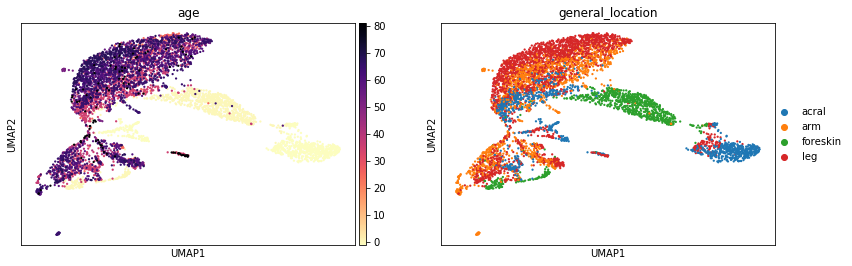

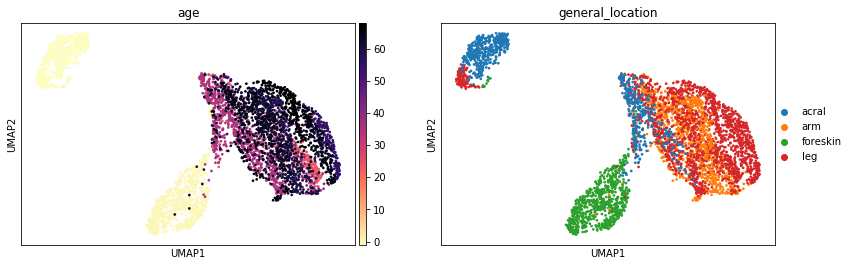

Completed


In [1]:
###############################################
###############################################
# Setup
# This chuck ingests pre-computed variables
###############################################
###############################################

# [Shift + Return] to run chunks 

###############################################

# settings
wkdir, s3dir = '/home/ubuntu/data/DL20181011_melanocyte_test_data', 'daniel.le-work/MEL_project'

%reload_ext autoreload
%autoreload 2
from scanpy_helpers import *
warnings.filterwarnings('ignore')
%matplotlib inline

# import data from s3
for file in ['adata_subset1', 'adata_subset2', 'full_adata', 'pre_adata','adata_subset1_KRT', 'raw_adata']:
#     ! aws s3 cp s3://{s3dir}/{file}.p {wkdir}/
    var = pickle.load((open(f'{wkdir}/{file}.p', 'rb')))
    exec(f'{file} = var')
    del var

# drop patients due to low cell count
adata_subset2_filtered = adata_subset2[[x not in ['A1015LM',
                                                'A1017LM',
                                                'A1012M'] for x in adata_subset2.obs.patient.tolist()]] 

# plot full data
sc.pl.umap(full_adata, color=['age','general_location'], cmap = 'magma_r')
sc.pl.umap(adata_subset2_filtered, color=['age','general_location'], cmap = 'magma_r')

print('Completed')


acral
   PC        f1
0   1  0.023438
1   2  0.706897
2   3  0.000000
3   4  0.000000
4   5  0.023438
5   6  0.007843
6   7  0.000000
7   8  0.000000
8   9  0.000000
9  10  0.000000


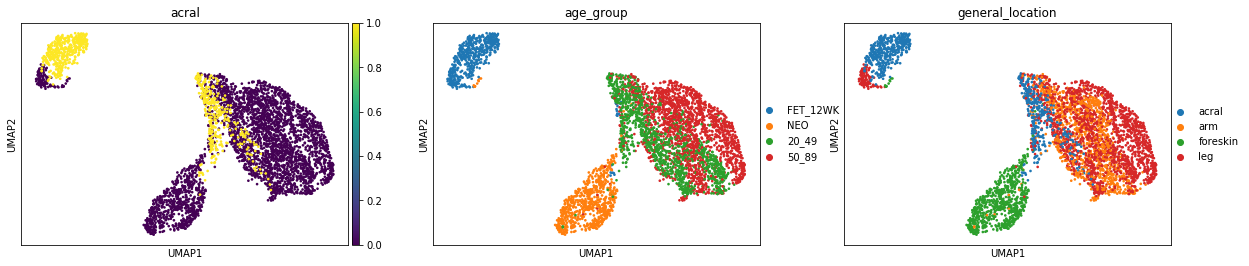

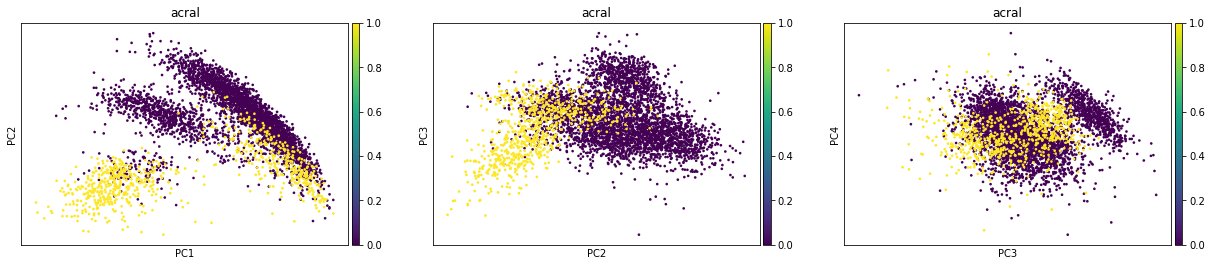

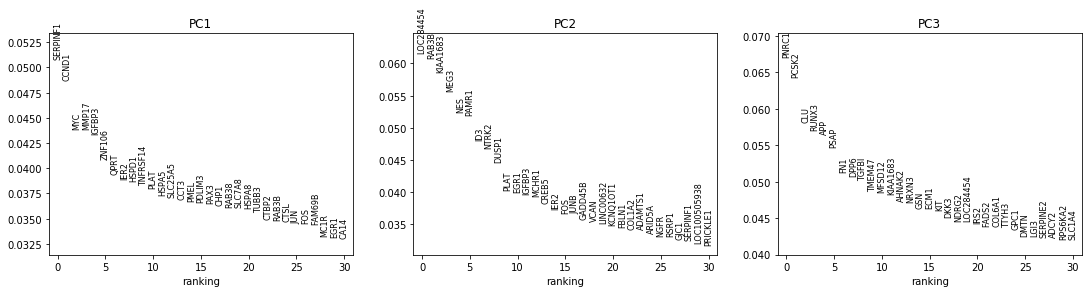

foreskin
   PC        f1
0   1  0.088154
1   2  0.000000
2   3  0.812095
3   4  0.250825
4   5  0.000000
5   6  0.000000
6   7  0.000000
7   8  0.000000
8   9  0.000000
9  10  0.008097


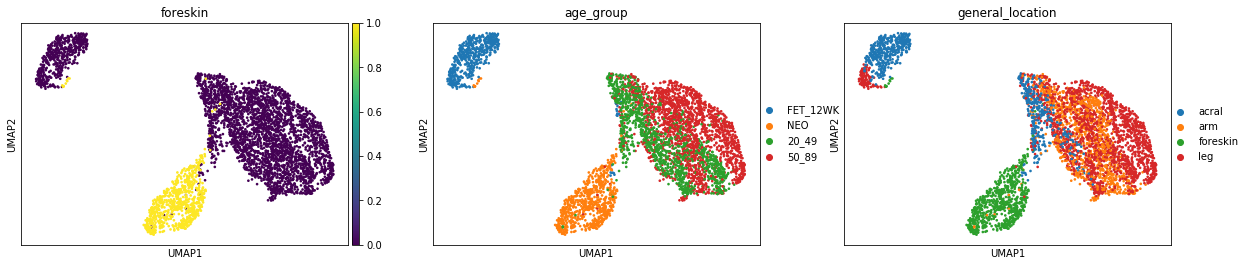

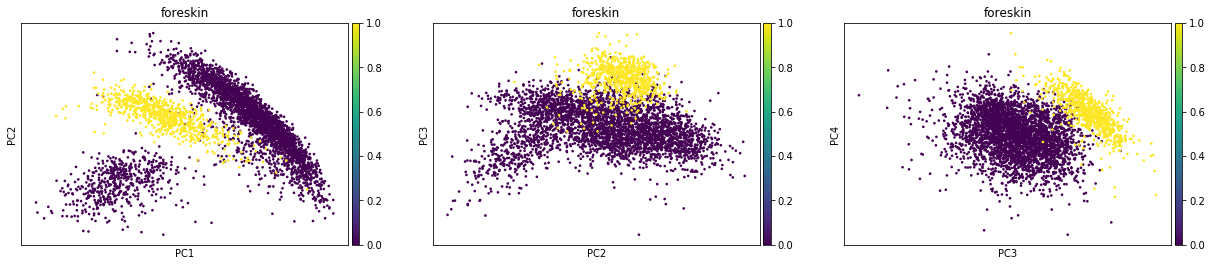

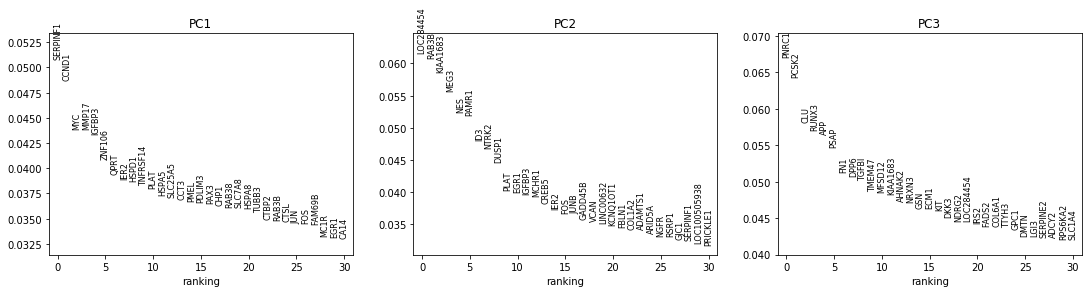

In [2]:
# determine which pc coordinate set best recalls general location label
input_adata = adata_subset2
pca_genes_df = pd.DataFrame()

for groupby in ['acral', 'foreskin']:
    print(groupby)
    input_adata.obs[groupby] = [x in [groupby] for x in input_adata.obs.general_location.values]

    results_list = []
    cell_list = input_adata.obs_names
    loc_list = input_adata.obs[groupby].values
    for PC in range(input_adata.obsm['X_pca'].shape[1]):
        PC_list = input_adata.obsm['X_pca'][:,PC]

        pred = PC_list # must be continuous
        res = np.array(loc_list) # must be categorical
        pred = pred.reshape(-1,1)
        res = res.reshape(-1,1)

        if len(np.unique(res)) == 1:
            acc = 0
        else:
            X_train, X_test, y_train, y_test = train_test_split(pred,
                                                                res,
                                                                test_size=0.33, 
                                                                random_state=42)
            # accurcy
            clf = LogisticRegression(multi_class='auto')
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            acc  = f1_score(y_true = y_test, 
                            y_pred = y_pred, 
                            average = 'binary')

            results_list.append(acc)
    print(pd.DataFrame({'PC':[x+1 for x in range(len(results_list))],
                  'f1':results_list}).head(10))

    sc.pl.umap(input_adata, color=[groupby,'age_group','general_location'])
    sc.pl.pca(input_adata, components=['1,2','2,3','3,4'], color=[groupby])
    sc.pl.pca_loadings(input_adata)
    
    # extract gene names from loadings
    ## top10 and bottom10 genes for top10 PCs
    for idx in range(10):
        pc_idx = idx

        pc_genes = (pd.DataFrame({'genes': input_adata.var_names.tolist(),
                                  'loadings': input_adata.varm['PCs'][:,pc_idx]})
                   .sort_values('loadings'))
        pc_genes['pc_idx'] = pc_idx
        pc_genes['idx'] = [x for x in range(len(pc_genes))]
        pc_genes['groupby'] = groupby
        pca_genes_df = pca_genes_df.append(pc_genes.head(10))
        pca_genes_df = pca_genes_df.append(pc_genes.tail(10))
        

In [ ]:
%%capture
###############################################
###############################################
# Compute union of differentially expressed gene among samples
# This chuck returns a dataframe of DE genes found in all samples
###############################################
###############################################

# Specify patients of interest
patientOIs = ['12WKM01', 'A1038LM']

# Specify feature to compare
groupby = 'louvain'

# Specify the number of top DE genes per test
n_genes = 20

###############################################

ranks_dict = {}
for idx, patientOI in enumerate(patientOIs):
    exec(f'global adata_{patientOI}')
    input_adata = adata_subset2
    patients = list(set(input_adata.obs.patient))
    type_dict = {'in':[patientOI],
                 'out':[x for x in patients if x != patientOI]}

    classify_type(raw_adata, input_adata, 'patient', type_dict, 'class_3')

    feature_dict = {'class_3':['in']}
    adata_subset3 = subset_adata_v3(raw_adata,feature_dict)
    adata_subset3 = process_adata(adata_subset3)
    pca_adata(adata_subset3, num_pcs=30)
    umap_adata(adata_subset3, res=0.2)
    sc.pl.umap(adata_subset3, color=['louvain','general_location'])

    exec(f'adata_{patientOI} = input_adata = adata_subset3')
    ranks_df = simple_rank (input_adata, groupby=groupby, n_genes=n_genes)
    ranks_df['patient'] = patientOI
    ranks_dict[patientOI] = ranks_df

In [ ]:
###############################################
###############################################
# Display summary of DE genes found in all samples
# This chuck displays MEL and all-cells UMAPS and gene annotations
###############################################
###############################################

# Specify patients and feature group
patient2feature = {'12WKM01':'0',
                   'A1038LM':'1'}

###############################################

full_list = []
for key,value in patient2feature.items():
    list_iter = list(set(ranks_dict[key][value].values.tolist()))
    full_list = full_list + list_iter

union_df = pd.DataFrame({'genes':full_list})['genes'].value_counts()
genes = union_df[union_df > 1].index.tolist()
sc.pl.umap(adata_subset2, color=genes+['general_location'], ncols = 2, cmap='magma_r')
sc.pl.umap(full_adata, color=genes+['general_location'], ncols = 2, cmap='magma_r')
out = symbol2field(genes)
full_report = ['{}: {}\n{}'.format(idx,
                            x['query'],
                            x['summary']) if ('summary' in x.keys()) else '{}: {}\n{}'.format(idx,
                            x['query'],
                            'N/A') for idx, x in enumerate(out)]
search_term = ''
output = [print(x) for x in full_report if search_term in x]

In [ ]:
# cluster with 2 acral samples + 1 fskin
patientOIs = ['12WKM01', 'A1038LM', 'FS030_LM', 'FS043_LM']

input_adata = adata_subset2
patients = list(set(input_adata.obs.patient))
type_dict = {'in':patientOIs,
             'out':[x for x in patients if x not in patientOIs]}

classify_type(raw_adata, input_adata, 'patient', type_dict, 'class_4')

feature_dict = {'class_4':['in']}
adata_subset4 = subset_adata_v3(raw_adata,feature_dict)
adata_subset4 = process_adata(adata_subset4)
pca_adata(adata_subset4, num_pcs=30)
umap_adata(adata_subset4, res=0.2)


In [ ]:
sc.pl.umap(adata_subset4, color=['louvain','general_location'])

In [ ]:


# fetal vs not
## compare to similar mouse studies

# foreskin vs not

# Look at adt mel outliers to see if there is correlation to fetal expression



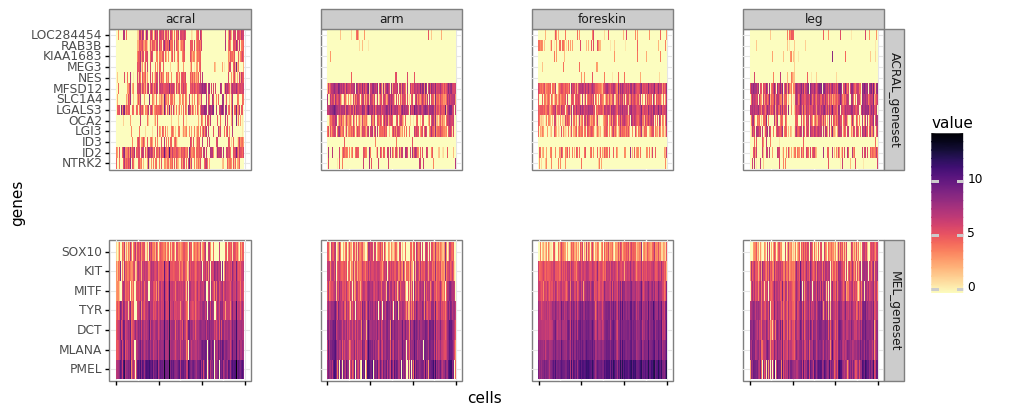

<ggplot: (-9223363267821511950)>


In [67]:
# heat map of Acral vs rest
input_adata = adata_subset2
subsampled_patients = []
canonical_genes = ['PMEL','MLANA','DCT','TYR','MITF','KIT','SOX10'] # ref all MEL lit
genes = ['NTRK2', 'ID2', 'ID3'] # from wilcoxon / t-test DE genes lists
pcOI = 1
pc_genes_head = pca_genes_df[[x == 'acral' and y == pcOI for x,y in zip(pca_genes_df['groupby'], pca_genes_df['pc_idx'])]].head().genes.values.tolist()
pc_genes_tail = pca_genes_df[[x == 'acral' and y == pcOI for x,y in zip(pca_genes_df['groupby'], pca_genes_df['pc_idx'])]].tail().genes.values.tolist()
genelist = genes + pc_genes_head + pc_genes_tail + canonical_genes

for loc in list(set(input_adata.obs.general_location)):
    subsampled_patients = subsampled_patients + (input_adata[input_adata.obs.general_location == loc]
                                                      .obs.sample(300)
                                                      .index
                                                      .tolist())

subsampled_df = input_adata[[x in subsampled_patients for x in input_adata.obs.index]]
cat, genesOI_df = prepare_dataframe(subsampled_df,
                                var_names = genelist,
                              groupby='general_location')  
genesOI_df = genesOI_df.reset_index().sort_values('general_location')
genesOI_df['index'] = [x for x in range(len(genesOI_df))]

plot_df = pd.melt(genesOI_df, id_vars=['general_location','index'])
plot_df['group'] = ['MEL_geneset' if x in canonical_genes else 'ACRAL_geneset' for x in plot_df.variable]
plot_df['variable'] = plot_df['variable'].astype(str).astype(CategoricalDtype(genelist, ordered=True))

plotnine.options.figure_size = (10,10)
print(ggplot(plot_df)
      +theme_bw()
      +theme(panel_spacing = 0.7,
            axis_text_x = element_blank(),
            aspect_ratio = 1)
     +geom_tile(aes('index','variable',fill='value'))
     +scale_fill_cmap('magma_r')
     +facet_grid('group~general_location', scales='free')
     +labs(x='cells',y='genes'))


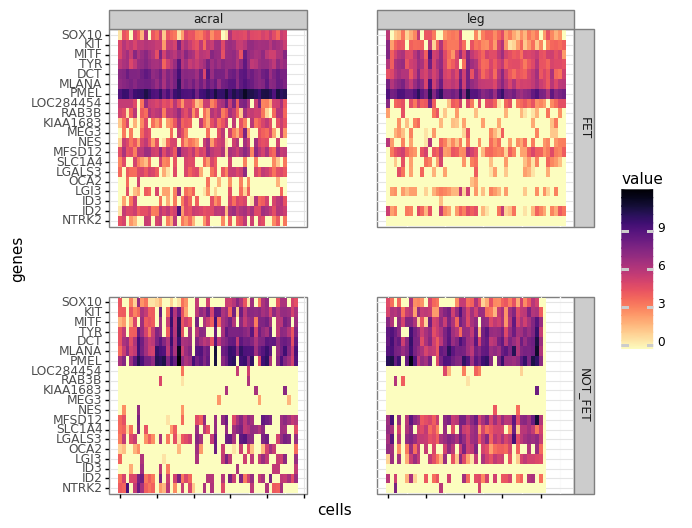

<ggplot: (-9223363267829685886)>


In [70]:
### (Fet vs non-fet age) by (acral vs leg location)

# heat map
input_adata = adata_subset2
input_adata.obs['age_label'] = ['FET' if x == 'FET_12WK' else 'NOT_FET' for x in input_adata.obs['age_group']]
input_adata.obs['age_label'] = input_adata.obs['age_label'].astype(str).astype(CategoricalDtype(['FET','NOT_FET']))
canonical_genes = ['PMEL','MLANA','DCT','TYR','MITF','KIT','SOX10'] # ref all MEL lit
genes = ['NTRK2', 'ID2', 'ID3'] # from wilcoxon / t-test DE genes lists
pcOI = 1
pc_genes_head = pca_genes_df[[x == 'acral' and y == pcOI for x,y in zip(pca_genes_df['groupby'], pca_genes_df['pc_idx'])]].head().genes.values.tolist()
pc_genes_tail = pca_genes_df[[x == 'acral' and y == pcOI for x,y in zip(pca_genes_df['groupby'], pca_genes_df['pc_idx'])]].tail().genes.values.tolist()
genelist = genes + pc_genes_head + pc_genes_tail + canonical_genes
return_df = pd.DataFrame()

for loc in ['leg','acral']: # locations in fetal sample
    for group in ['FET','NOT_FET']:
        slice_df = input_adata[[x == loc and y == group for x,y in zip(input_adata.obs.general_location, input_adata.obs.age_label)]]
        slice_df = slice_df[[x in slice_df.obs.sample(50).index.tolist() for x in slice_df.obs.index.tolist()]]
        cat, genesOI_df = prepare_dataframe(slice_df,
                                            var_names = genelist,
                                            groupby='age_label')  
        genesOI_df = genesOI_df.reset_index()
        genesOI_df['general_location'] = loc
        genesOI_df['index'] = [x for x in range(len(genesOI_df))]
        return_df = return_df.append(genesOI_df)

plot_df = pd.melt(return_df, id_vars=['index','age_label','general_location'])
plot_df['variable'] = plot_df['variable'].astype(str).astype(CategoricalDtype(genelist, ordered=True))

plotnine.options.figure_size = (6,6)
print(ggplot(plot_df)
      +theme_bw()
      +theme(panel_spacing = 0.7,
            axis_text_x = element_blank(),
            aspect_ratio = 1)
     +geom_tile(aes('index','variable',fill='value'))
     +scale_fill_cmap('magma_r')
     +facet_grid('age_label~general_location', scales='free')
     +labs(x='cells',y='genes'))

In [ ]:
# heat map of foreskin vs rest
input_adata = adata_subset2
subsampled_patients = []
canonical_genes = ['PMEL','MLANA','DCT','TYR','MITF','KIT','SOX10'] # ref all MEL lit
pcOI = 1
pc_genes_head = pca_genes_df[[x == 'foreskin' and y == pcOI for x,y in zip(pca_genes_df['groupby'], pca_genes_df['pc_idx'])]].head().genes.values.tolist()
pc_genes_tail = pca_genes_df[[x == 'foreskin' and y == pcOI for x,y in zip(pca_genes_df['groupby'], pca_genes_df['pc_idx'])]].tail().genes.values.tolist()
genelist = pc_genes_head + pc_genes_tail + canonical_genes

for loc in list(set(input_adata.obs.general_location)):
    subsampled_patients = subsampled_patients + (input_adata[input_adata.obs.general_location == loc]
                                                      .obs.sample(300)
                                                      .index
                                                      .tolist())

subsampled_df = input_adata[[x in subsampled_patients for x in input_adata.obs.index]]
cat, genesOI_df = prepare_dataframe(subsampled_df,
                                var_names = genelist,
                              groupby='general_location')  
genesOI_df = genesOI_df.reset_index().sort_values('general_location')
genesOI_df['index'] = [x for x in range(len(genesOI_df))]

plot_df = pd.melt(genesOI_df, id_vars=['general_location','index'])
plot_df['group'] = ['MEL_geneset' if x in canonical_genes else 'ACRAL_geneset' for x in plot_df.variable]
plot_df['variable'] = plot_df['variable'].astype(str).astype(CategoricalDtype(genelist, ordered=True))

plotnine.options.figure_size = (10,10)
print(ggplot(plot_df)
      +theme_bw()
      +theme(panel_spacing = 0.7,
            axis_text_x = element_blank(),
            aspect_ratio = 1)
     +geom_tile(aes('index','variable',fill='value'))
     +scale_fill_cmap('magma_r')
     +facet_grid('group~general_location', scales='free')
     +labs(x='cells',y='genes'))